# Monitoren eines (Temperatur-)Sensors 
Im Folgenden beschreiben wir, wie wir die Funktionstüchtigkeit des Tempertursensor aus dem Smart Citizen Kit überwachen und ungewöhnliches Temperaturverhalten aufspüren können.

Benötigte python Pakete lassen sich mit `pip` wie folgt installieren:

`pip install pandas numpy matplotlib sklearn`

In [1]:
# Notwendige Pakete
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scdata.io.read_api import ScApiDevice
from sklearn import svm


## Daten laden
Wir laden uns exemplarisch Daten eines Smart Citizen Kits aus Würzburg (Sanderau).

In [2]:
kit_id = '13045' # Kit-Id eintragen
frequency = '1H' # Zeit zwischen zwei aufeinanderfolgenden Messungen ('1D', '1H', '6H')
temp_sensor = ['TEMP']
hum_sensor = ['HUM']
pressure_sensor = ['PRESS']
light_sensor = ['LIGHT']

# Laden
print("Downloading data fuer kit-id: " + str(kit_id))
device = ScApiDevice(kit_id)
kit_data = device.get_device_data(start_date = None,
                              end_date = None, 
                              frequency = frequency, 
                              clean_na = None)
# Reskalieren
kit_data_rescale = kit_data.apply(lambda x: (x - np.mean(x))/np.std(x))


[SUCCESS]: Device 13045 loaded successfully from API


## Wie verhält sich der Temperatursensor über die Zeit hinweg?

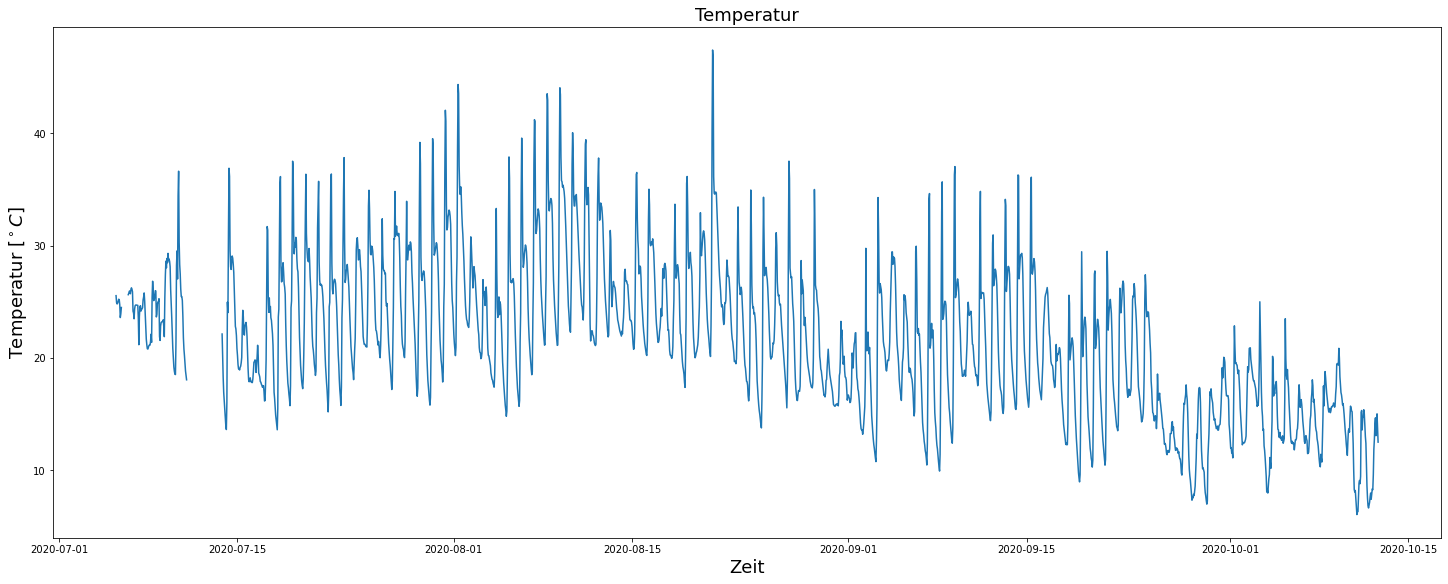

In [3]:
label_font_size = 18
fig, axs = plt.subplots(1, 1, constrained_layout=True,figsize=(20,8))
axs.plot(kit_data[temp_sensor])
axs.set_title('Temperatur', fontsize=label_font_size)
axs.set_ylabel(r'Temperatur [$^\circ C$]', fontsize=label_font_size)  
axs.set_xlabel('Zeit',fontsize=label_font_size)
plt.show()

## Gibt es sinnvolle/vordefinierte Grenzwerte?
Die Temperaturhöchstewerte in Deutschland liegen im Bereich von 42 Grad laut [Statista](https://de.statista.com/statistik/daten/studie/13066/umfrage/hoechsttemperaturen-in-ausgewaehlten-orten-deutschlands/).  
42 Grad könnte also ein sinnvolles oberes Limit für den Temperatursensor sein.
Wir zeichnen diese Grenze als rote Linie in die Grafik ein.

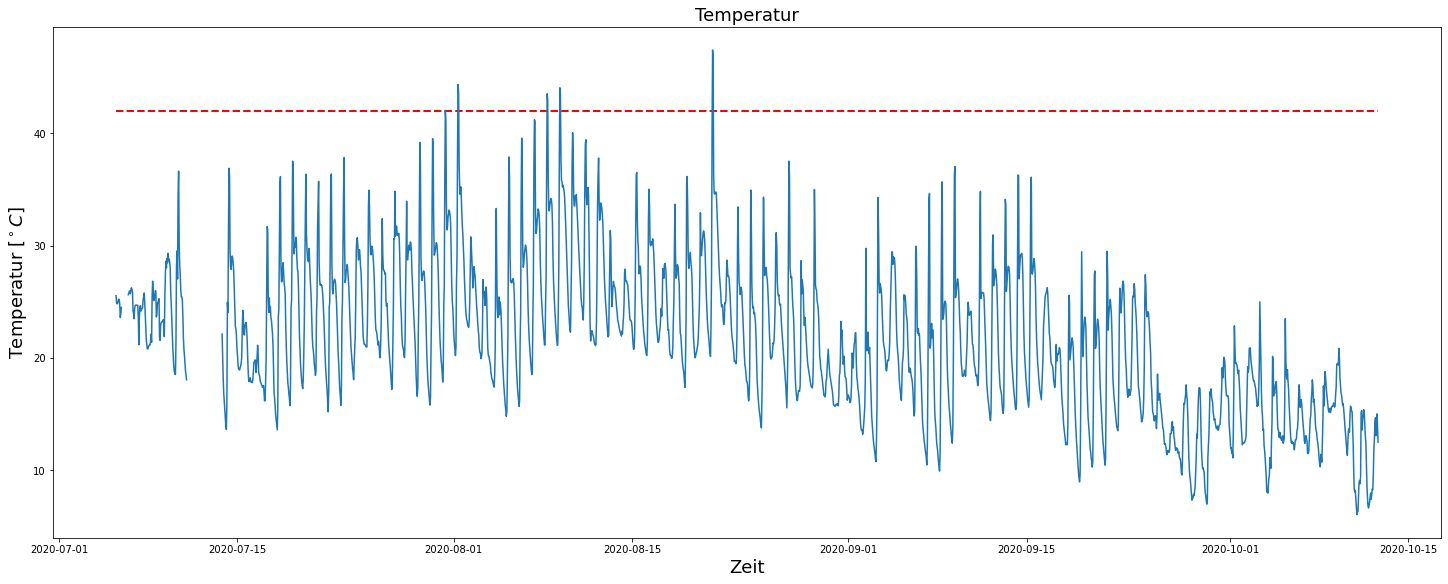

In [4]:
fig, axs = plt.subplots(1, 1, constrained_layout=True,figsize=(20,8))
axs.plot(kit_data[temp_sensor])
axs.set_title('Temperatur', fontsize=label_font_size)
axs.set_ylabel(r'Temperatur [$^\circ C$]', fontsize=label_font_size)  
axs.set_xlabel('Zeit',fontsize=label_font_size)
axs.hlines([42], min(kit_data.index), max(kit_data.index),
           color = "red", linewidth=2.0, linestyle = '--')
plt.show()

**Ergebnis:**\
Der Sensor überschreitet an manchen Tagen im Jahr den Grenzwert, was Fragen aufwirft wie:
* Ist der Sensor richtig kalibriert?
* Ist der Sensor direkter Sonnenstrahlung ausgesetzt?
* Werden die Daten richtig abgespeichert und heruntergeladen?
* ...
* Ist der Sensor defekt?

## Flexible/Datenbasierte Grenzwerte?
In solch einem Fall versucht man weitere messbare Größen mit dem Sensor in Verbindung zu bringen. Für das Smart Citizen Kit ist das einfach möglich, da das Kit aus einer Reihe von Sensoren besteht (Licht, Luftdruck, Luftfeuchtigkeit).

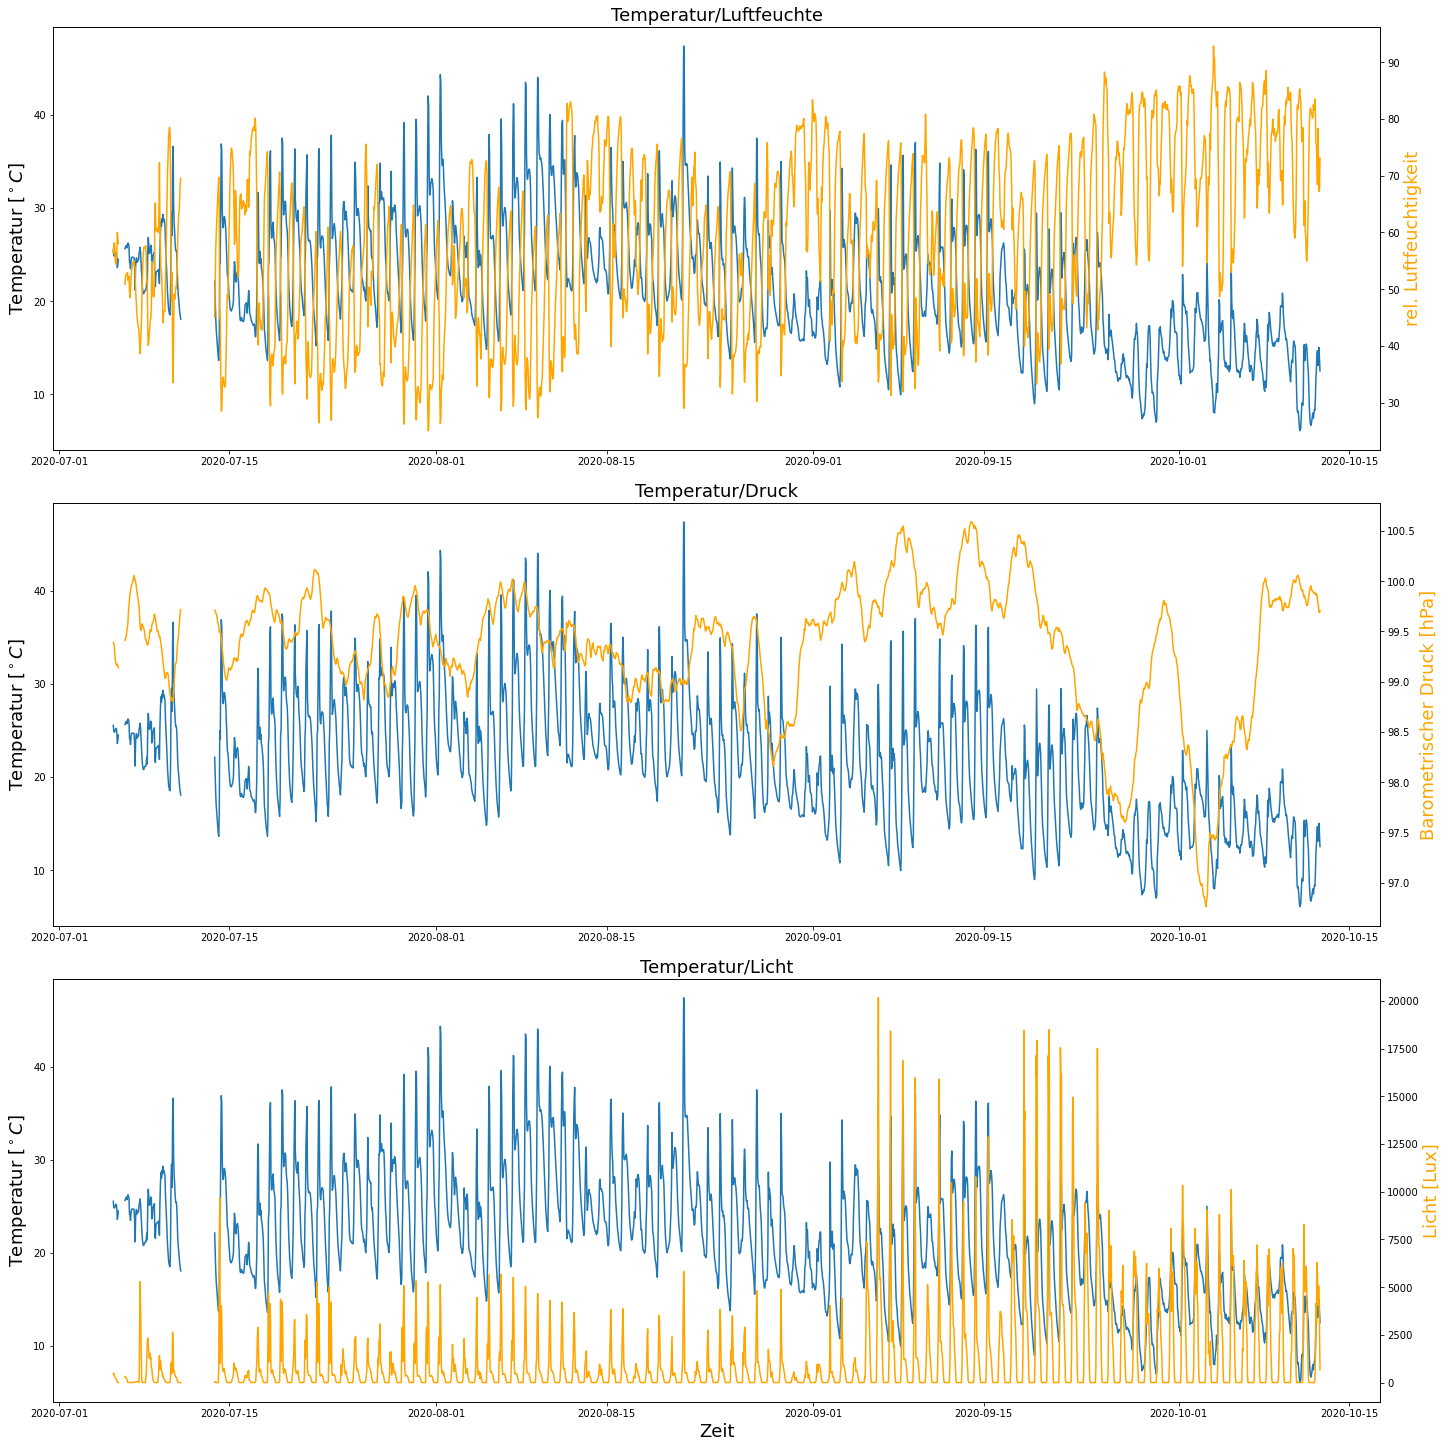

In [5]:
label_font_size = 18
snd_axis_color = "orange"

fig, axs = plt.subplots(3, 1, constrained_layout=True,figsize=(20,20))
# Luftfeucht. vs Temperatur
axs[0].plot(kit_data[temp_sensor])
axs[0].set_title('Temperatur/Luftfeuchte', fontsize=label_font_size)
axs[0].set_ylabel(r'Temperatur [$^\circ C$]', fontsize=label_font_size)  

ax02 = axs[0].twinx()  # Zweite gespiegelte axe
ax02.set_ylabel('rel. Luftfeuchtigkeit', color=snd_axis_color ,fontsize=label_font_size) 
ax02.plot(kit_data[hum_sensor], color=snd_axis_color)

# Temperatur vs Luftdruck
axs[1].plot(kit_data[temp_sensor])
axs[1].set_title('Temperatur/Druck', fontsize=label_font_size)
axs[1].set_ylabel(r'Temperatur [$^\circ C$]',fontsize=label_font_size)  

ax02 = axs[1].twinx()  # Zweite gespiegelte axe
ax02.set_ylabel(r'Barometrischer Druck [hPa]', color=snd_axis_color ,fontsize=label_font_size) 
ax02.plot(kit_data[pressure_sensor], color=snd_axis_color)

# Licht vs Temperatur
axs[2].plot(kit_data[temp_sensor])
axs[2].set_title('Temperatur/Licht', fontsize=label_font_size)
axs[2].set_ylabel(r'Temperatur [$^\circ C$]',fontsize=label_font_size)
axs[2].set_xlabel('Zeit',fontsize=label_font_size)

ax02 = axs[2].twinx()  # Zweite gespiegelte axe
ax02.set_ylabel(r'Licht [Lux]', color=snd_axis_color ,fontsize=label_font_size) 
ax02.plot(kit_data[light_sensor], color=snd_axis_color)
plt.show()

**Ergebnis der Datenanalyse:**  
Rein augenscheinlich könnten die Sensordaten *Druck (p)* und *Luftfeuchtigkeit (l)* mit der *Temperatur (T)* zusammenhängen. 


Also könnten wir versuchen das Normalverhalten des Sensors über folgendes Model zu nachzuahmen:

$$T = svm.model(p,l)$$

SVM steht hier für "Support Vector Machine" und ist ein Machine Learning Verfahren zur Modellierung von nicht linearen Abhängikeiten (Nähre Infos unter [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)).


Im folgenden legen wir nun zwei Zeitabschnitte fest.  
Anhand der Beobachtungen im **Trainingszeitraum** (markiert durch vertikale blaue Striche) lernt das SVM Modell wie sich die Temperatur mittels Druck und Luftfeuchtigkeit beschreiben lässt. Den **Validierungszeitraum** (markiert durch vertikale grüne Striche) verwenden wir, um die Güte des Modells zu beurteilen bzw. um unnormale Werte aufzuspüren.

In [6]:
# Definiere Trainings- und Validierungszeitraeume
training_start_date = '2020-07-15' 
training_end_date = '2020-10-01'
validation_start_date = '2020-10-02'
validation_end_date = '2020-10-08'

# Definiere welche Groessen in das Model eingehen
features = hum_sensor + pressure_sensor #+ light_sensor
response = temp_sensor # Was soll eigentlich beschrieben werden?

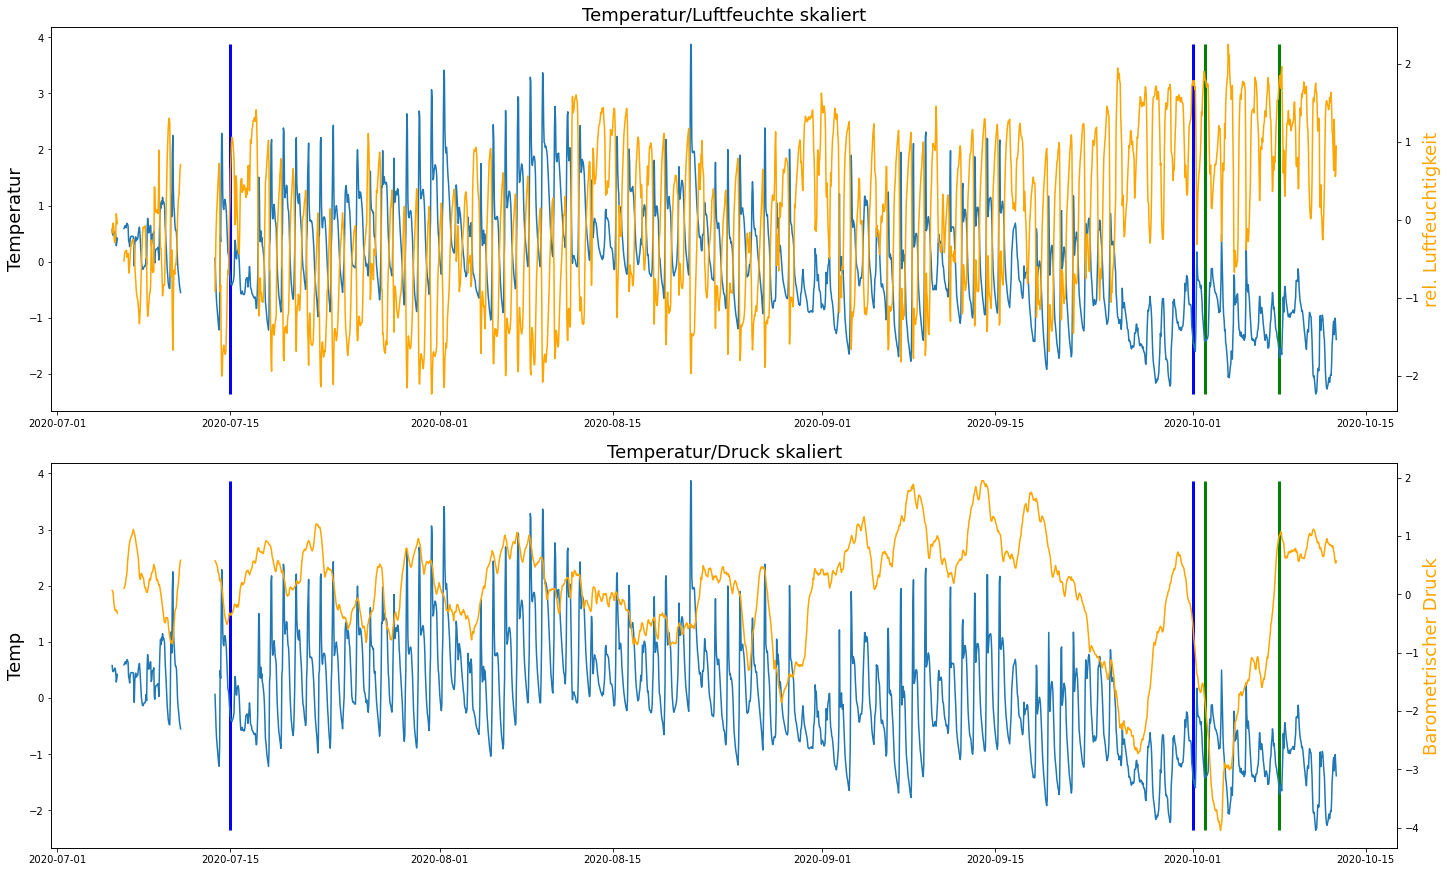

In [7]:
label_font_size = 18
snd_axis_color = "orange"
training_color = "blue"
validation_color = "green"
line_width_vertical = 3
temp_min = np.min(kit_data_rescale[temp_sensor])
temp_max = np.max(kit_data_rescale[temp_sensor])


fig, axs = plt.subplots(2, 1, constrained_layout=True,figsize=(20,12))
# Luftfeuchtigkeit
axs[0].plot(kit_data_rescale[temp_sensor])
axs[0].set_title('Temperatur/Luftfeuchte skaliert', fontsize=label_font_size)
axs[0].set_ylabel(r'Temperatur', fontsize=label_font_size)  
axs[0].vlines([pd.to_datetime(training_start_date),
               pd.to_datetime(training_end_date)], temp_min, temp_max, color = training_color, linewidth=line_width_vertical)
axs[0].vlines([pd.to_datetime(validation_start_date), 
               pd.to_datetime(validation_end_date)], temp_min, temp_max, color = validation_color,                linewidth=line_width_vertical)

ax02 = axs[0].twinx()  # Zweite gespiegelte axe
ax02.set_ylabel('rel. Luftfeuchtigkeit', color=snd_axis_color ,fontsize=label_font_size) 
ax02.plot(kit_data_rescale[hum_sensor], color=snd_axis_color)

# Druck
axs[1].plot(kit_data_rescale[temp_sensor])
axs[1].set_title('Temperatur/Druck skaliert', fontsize=label_font_size)
axs[1].set_ylabel(r'Temp',fontsize=label_font_size)  
axs[1].vlines([pd.to_datetime(training_start_date),
               pd.to_datetime(training_end_date)], temp_min, temp_max, color = training_color,                    linewidth=line_width_vertical)
axs[1].vlines([pd.to_datetime(validation_start_date), 
               pd.to_datetime(validation_end_date)], temp_min, temp_max, color = validation_color,                linewidth=line_width_vertical)

ax02 = axs[1].twinx()  # Zweite gespiegelte axe
ax02.set_ylabel(r'Barometrischer Druck', color=snd_axis_color ,fontsize=label_font_size) 
ax02.plot(kit_data_rescale[pressure_sensor], color=snd_axis_color)

### Das Model trainieren

In [8]:
# Einteilung in Trainings- und Validierungsdaten
training_scaled = kit_data_rescale[(kit_data_rescale.index >= training_start_date) & (kit_data_rescale.index <= training_end_date)]
validation_scaled = kit_data_rescale[(kit_data_rescale.index >= validation_start_date) & (kit_data_rescale.index <= validation_end_date)]

# SVM Model trainieren
regr = svm.SVR()
regr.fit(training_scaled[features], np.ravel(training_scaled[response]))
validation_scaled['prediction'] = np.array(regr.predict(validation_scaled[features]))

# Fehler/Residuen berechnen
validation_scaled['residuals'] =  np.array(validation_scaled['prediction']) - np.ravel(validation_scaled[response])
validation_scaled['residuals_norm'] = (validation_scaled['residuals'] - np.mean(validation_scaled['residuals']))/np.std(validation_scaled['residuals'])

## Vergleiche die Vorhersagen des Modells mit den tatsächlichen Temperaturen 

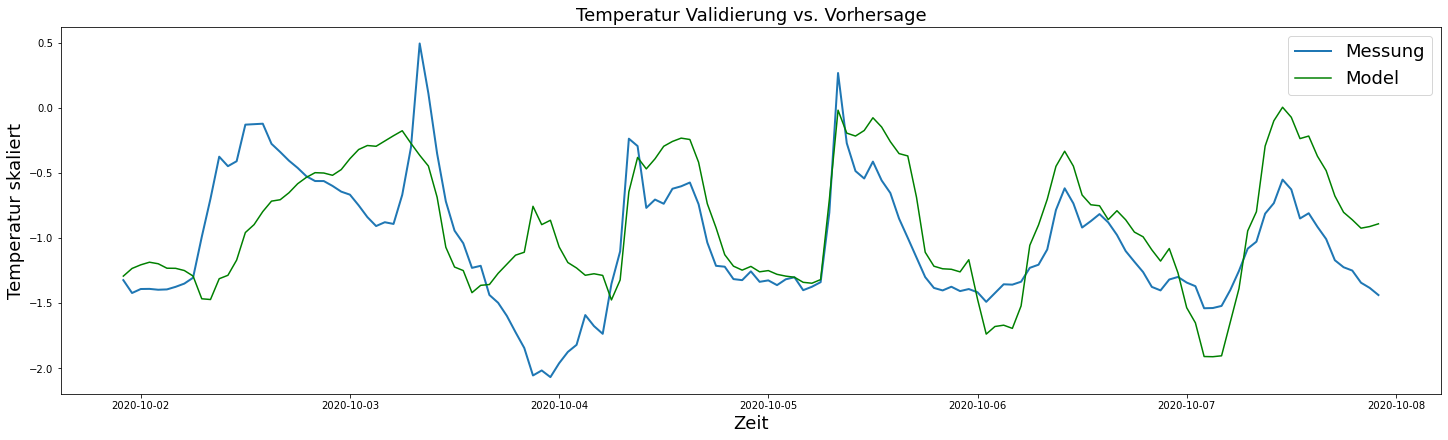

In [9]:
# Vergleich der Modelvorhersage mit den tatsaechlichen Werten 
linewidth_original = 2.0
fig2, axs = plt.subplots(1, 1, constrained_layout=True,figsize=(20,6))
axs.plot(validation_scaled[temp_sensor], linewidth = linewidth_original)
axs.plot(validation_scaled['prediction'], color = "green")
axs.set_title('Temperatur Validierung vs. Vorhersage', fontsize=label_font_size)
axs.set_ylabel(r'Temperatur skaliert',fontsize=label_font_size)
axs.set_xlabel('Zeit',fontsize=label_font_size)
axs.legend(['Messung', 'Model'], fontsize=label_font_size)
plt.show()

## Was bringt uns das SVM Modell?
Die Differenz zwischen den tatsächlich gemessenen und den vom Modell erwarteten Werten, liefert uns eine geeignete Größe (Fehler), die wir monitoren können. Sinnvolle Grenzwerte (control limits) für diese Fehler können datenbasiert mittels statistischen Verfahren bestimmt werden. Wir arbeiten im Folgenden mit der zweifachen Standardabweichung.

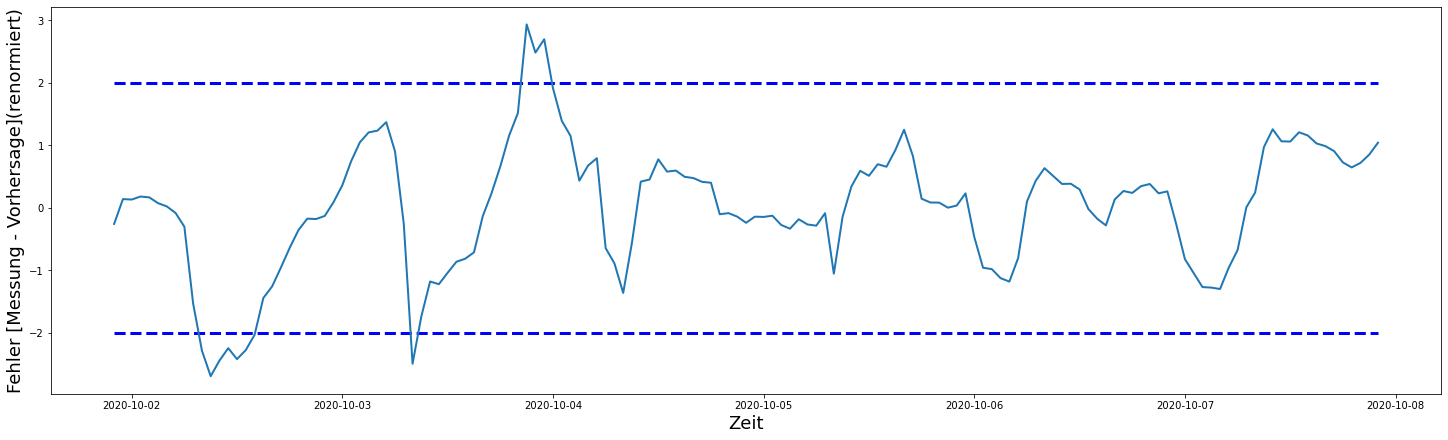

In [10]:
# Plotte den Fehler und die zweifache Standardabweichung
fig3, axs = plt.subplots(1, 1, constrained_layout=True,figsize=(20,6))
axs.plot(validation_scaled['residuals_norm'], linewidth = linewidth_original)
axs.hlines([-2, +2], min(validation_scaled.index), max(validation_scaled.index),
           color = training_color, linewidth=line_width_vertical, linestyle = '--')
axs.set_ylabel(r'Fehler [Messung - Vorhersage](renormiert)',fontsize=label_font_size)
axs.set_xlabel('Zeit',fontsize=label_font_size)
plt.show()

**Ergebnis:**  
Der Sensor überschreitet auch hier den Grenzwert an gewissen Tagen. Was erneut Fragen aufwirft wie:
* Ist mein SVM Modell generell gut genug um die Temperatur (die Norm) zu beschreiben?
* Sind die Hyper-Parameter des SVM Modells richtig gewählt?
* Enthalten die Trainingsdaten alle möglichen Fälle/Situationen (Frühling, Sommer, Herbst, Winter)?
* ...
* Ist der Sensor defekt?